## Predicting the number of customers

In [1]:
# Read in data from ETL.py file
%run '../scripts/ETL.py' '../scripts/paths.json'

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 01:49:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/04 01:49:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
data = spark.read.parquet("../data/tables/full_join.parquet")

In [3]:
data.limit(5)

merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,postcode,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id
Nullam Nisl Insti...,15912561882,shoe shops,3.72,b,Allison Stevens,60866 Miller Avenue,NSW,1193,Female,15912561882,28.083206954036427,bf851e23-d713-441...,2021-09-06,6305,6834
Nullam Nisl Insti...,15912561882,shoe shops,3.72,b,Allison Stevens,60866 Miller Avenue,NSW,1193,Female,15912561882,13.671791104152105,0cad39e4-71f7-47c...,2021-11-27,6305,6834
Nullam Nisl Insti...,15912561882,shoe shops,3.72,b,Lawrence Tyler,3511 Victoria Meadow,NSW,2212,Male,15912561882,235.75679877020391,3fdd2acd-3b77-4c2...,2021-06-18,18983,36103
Nullam Nisl Insti...,15912561882,shoe shops,3.72,b,Ryan Crawford,7107 Michelle Har...,NSW,1126,Male,15912561882,284.642162569933,f8303e6b-78f6-481...,2021-04-29,12285,37894
Nullam Nisl Insti...,15912561882,shoe shops,3.72,b,Alexander Skinner,35694 Kimberly Co...,VIC,3053,Male,15912561882,213.64355235308224,4b193807-a752-4f6...,2021-07-26,9248,147322


In [16]:
subset = data.select("merchant_name", "merchant_abn", "order_datetime")

In [17]:
subset.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: date (nullable = true)



### Creating Features By Day

In [4]:
from pyspark.sql import functions as F

states = data.groupBy("merchant_name", "merchant_abn", "order_datetime").pivot('state').count().fillna(0)
states.limit(5)

merchant_name,merchant_abn,order_datetime,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
Mollis Duis Consu...,73619221575,2022-01-26,0,0,2,0,1,0,0,1,0
Tellus Aenean Cor...,27326652377,2021-03-21,0,0,3,0,2,1,1,0,0
Nisi Limited,15269431008,2021-11-25,0,0,12,0,12,3,0,7,1
Maecenas Mi LLC,18653260078,2021-03-22,0,0,2,0,0,1,0,2,2
Commodo Ipsum Ind...,19492220327,2021-12-09,0,0,1,0,0,0,0,0,0


In [5]:
total_count = data.groupBy("merchant_name", "merchant_abn", "order_datetime").count()
total_count.limit(5)

merchant_name,merchant_abn,order_datetime,count
Nullam Nisl Insti...,15912561882,2021-03-07,9
Nullam Nisl Insti...,15912561882,2021-03-03,15
Aliquet Sem Ut LLP,18651012250,2021-12-10,1
In Consequat LLC,22900076341,2021-07-08,1
In Consequat LLC,22900076341,2021-12-31,1


In [6]:
genders = data.groupBy("merchant_name", "merchant_abn", "order_datetime").pivot('gender').count().fillna(0)
genders.limit(5)

merchant_name,merchant_abn,order_datetime,null,Female,Male,Undisclosed
In Consequat LLC,22900076341,2021-07-08,0,1,0,0
Neque Incorporated,72857570096,2021-03-27,0,2,4,1
Nullam Nisl Insti...,15912561882,2021-03-03,0,5,10,0
Nunc Ullamcorper ...,30801495844,2022-02-18,0,3,8,0
Scelerisque Corpo...,94729574738,2021-12-26,0,17,19,5


In [7]:
states = states.withColumnRenamed("merchant_name", "merchant_name_st") \
    .withColumnRenamed("merchant_abn", 'merchant_abn_st') \
    .withColumnRenamed("order_datetime", 'order_datetime_st')

genders = genders.withColumnRenamed("merchant_name", "merchant_name_g") \
    .withColumnRenamed("merchant_abn", 'merchant_abn_g') \
    .withColumnRenamed("order_datetime", 'order_datetime_g')

In [8]:
# Joining data with features
joined = total_count.join(states,(total_count["merchant_name"] == states["merchant_name_st"]) & \
                 (total_count["merchant_abn"] == states["merchant_abn_st"]) & \
                 (total_count["order_datetime"] == states["order_datetime_st"])) \
    .join(genders,(total_count["merchant_name"] == genders["merchant_name_g"]) & \
                 (total_count["merchant_abn"] == genders["merchant_abn_g"]) & \
                 (total_count["order_datetime"] == genders["order_datetime_g"]))

In [9]:
agg = joined.drop("merchant_name_st", "merchant_abn_st", "order_datetime_st", 
                  "merchant_name_g", "merchant_abn_g", "order_datetime_g")

agg.limit(5)

merchant_name,merchant_abn,order_datetime,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed
A Aliquet Ltd,22578135006,2021-03-30,3,0,0,2,0,0,1,0,0,0,0,3,0,0
A Aliquet Ltd,22578135006,2021-03-31,1,0,0,0,0,1,0,0,0,0,0,1,0,0
A Aliquet Ltd,22578135006,2021-04-02,1,0,0,1,0,0,0,0,0,0,0,1,0,0
A Aliquet Ltd,22578135006,2021-04-04,1,0,0,1,0,0,0,0,0,0,0,0,1,0
A Aliquet Ltd,22578135006,2021-04-07,1,0,0,0,0,0,0,0,1,0,0,0,0,1


### Creating Features By Month

In [32]:
from pyspark.sql.functions import year, month

data_month = data.withColumn('year',year(data.order_datetime))
data_month = data_month.withColumn('month',month(data_month.order_datetime))
data_month.limit(5)

states_month = data_month.groupBy("merchant_name", "merchant_abn", "year", "month", "categories").pivot('state').count().fillna(0)
total_count_month = data_month.groupBy("merchant_name", "merchant_abn", "year", "month", "categories").count()
genders_month = data_month.groupBy("merchant_name", "merchant_abn", "year", "month", "categories").pivot('gender').count().fillna(0)

states_month = states_month.withColumnRenamed("merchant_name", "merchant_name_st") \
    .withColumnRenamed("merchant_abn", 'merchant_abn_st') \
    .withColumnRenamed("year", 'year_st') \
    .withColumnRenamed("month", 'month_st') \
    .withColumnRenamed("categories", "categories_st")
genders_month = genders_month.withColumnRenamed("merchant_name", "merchant_name_g") \
    .withColumnRenamed("merchant_abn", 'merchant_abn_g') \
    .withColumnRenamed("year", 'year_g') \
    .withColumnRenamed("month", 'month_g') \
    .withColumnRenamed("categories", "categories_g")

joined_month = total_count_month.join(states_month,(total_count_month["merchant_name"] == states_month["merchant_name_st"]) & \
                 (total_count_month["merchant_abn"] == states_month["merchant_abn_st"]) & \
                 (total_count_month["year"] == states_month["year_st"]) & \
                 (total_count_month["month"] == states_month["month_st"]))\
    .join(genders_month,(total_count_month["merchant_name"] == genders_month["merchant_name_g"]) & \
                 (total_count_month["merchant_abn"] == genders_month["merchant_abn_g"]) & \
                 (total_count_month["year"] == genders_month["year_g"]) & \
                 (total_count_month["month"] == genders_month["month_g"]))

agg_month = joined_month.drop("merchant_name_st", "merchant_abn_st", "year_st", "month_st", "categories_st",
                  "merchant_name_g", "merchant_abn_g", "year_g", "month_g", "categories_g")

agg_month.limit(20)

merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed
Magna Duis Inc.,80067991455,2021,6,art dealers and g...,1,0,0,0,0,0,0,0,1,0,0,0,1,0
Dignissim LLP,99410502449,2021,6,computer programm...,18,0,0,7,0,1,3,1,5,1,0,11,6,1
Cras Sed Leo Corp.,96244711717,2021,9,"gift, card, novel...",376,0,2,121,3,56,43,17,76,58,0,173,157,46
Duis Risus Corp.,51759688899,2021,5,"watch, clock, and...",3,0,0,2,0,0,0,0,1,0,0,1,0,2
Quis Corporation,50913027463,2021,12,lawn and garden s...,50,0,1,18,2,4,5,3,9,8,0,20,28,2
Ultrices Iaculis ...,88253903277,2022,2,"hobby, toy and ga...",1,0,0,0,0,1,0,0,0,0,0,1,0,0
Dolor Donec Corpo...,74061266589,2021,2,"equipment, tool, ...",1,0,0,0,0,0,1,0,0,0,0,0,1,0
Pharetra Nibh Ali...,67019805160,2021,11,"opticians, Optica...",295,0,1,96,5,39,28,10,62,54,0,139,125,31
Nec Incorporated,82368304209,2021,11,telecom,362,0,4,99,2,52,40,15,86,64,0,156,168,38
Sed PC,12483082042,2021,9,"opticians, optica...",184,0,4,54,1,23,18,5,44,35,0,79,93,12


In [33]:
agg_month.count()

46717

In [34]:
agg_month.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- count: long (nullable = false)
 |-- null: long (nullable = true)
 |-- ACT: long (nullable = true)
 |-- NSW: long (nullable = true)
 |-- NT: long (nullable = true)
 |-- QLD: long (nullable = true)
 |-- SA: long (nullable = true)
 |-- TAS: long (nullable = true)
 |-- VIC: long (nullable = true)
 |-- WA: long (nullable = true)
 |-- null: long (nullable = true)
 |-- Female: long (nullable = true)
 |-- Male: long (nullable = true)
 |-- Undisclosed: long (nullable = true)



In [35]:
agg_projection = agg_month.select("merchant_name", "merchant_abn", "count", "year", "month")
agg_projection.limit(5)

merchant_name,merchant_abn,count,year,month
Lectus Company,71274812967,49,2021,5
Vivamus Non Corpo...,38325541616,22,2021,10
Mi Lacinia Mattis...,62583219931,644,2021,11
Elit Elit PC,96809815920,1,2021,7
Mollis Phasellus ...,32821775372,1,2021,7


In [36]:
agg_projection = agg_projection.withColumn("prev_year", \
              when(agg_projection["month"] == 1, agg_projection['year'] - 1).otherwise(agg_projection['year']))
agg_projection = agg_projection.withColumn("prev_month", \
              when(agg_projection["month"] == 1, 12).otherwise(agg_projection['month'] - 1))
agg_projection = agg_projection.drop("year", "month")
agg_projection = agg_projection.withColumnRenamed("count", "future_count") \
                            .withColumnRenamed("merchant_name", "p_merchant_name") \
                            .withColumnRenamed("merchant_abn", "p_merchant_abn")
agg_projection.limit(5)

p_merchant_name,p_merchant_abn,future_count,prev_year,prev_month
Lectus Company,71274812967,49,2021,4
Vivamus Non Corpo...,38325541616,22,2021,9
Mi Lacinia Mattis...,62583219931,644,2021,10
Elit Elit PC,96809815920,1,2021,6
Mollis Phasellus ...,32821775372,1,2021,6


In [79]:
final_data = agg_month.join(agg_projection, (agg_month.merchant_name == agg_projection.p_merchant_name) & 
                           (agg_month.merchant_abn == agg_projection.p_merchant_abn) & 
                           (agg_month.year == agg_projection.prev_year) & 
                           (agg_month.month == agg_projection.prev_month), how = 'inner')

final_data = final_data.drop("p_merchant_name", "p_merchant_abn", "prev_year", "prev_month")
final_data.limit(5)

merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed,future_count
Magna Duis Inc.,80067991455,2021,6,art dealers and g...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
Dignissim LLP,99410502449,2021,6,computer programm...,18,0,0,7,0,1,3,1,5,1,0,11,6,1,21
Cras Sed Leo Corp.,96244711717,2021,9,"gift, card, novel...",376,0,2,121,3,56,43,17,76,58,0,173,157,46,418
Duis Risus Corp.,51759688899,2021,5,"watch, clock, and...",3,0,0,2,0,0,0,0,1,0,0,1,0,2,7
Quis Corporation,50913027463,2021,12,lawn and garden s...,50,0,1,18,2,4,5,3,9,8,0,20,28,2,22


### Modelling

In [80]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd

# https://goodboychan.github.io/python/datacamp/pyspark/2020/08/11/01-Regression-in-PySpark.html#One-Hot-Encoding

In [81]:
agg1 = StringIndexer(inputCol='merchant_name', outputCol='merchant_name_idx').fit(final_data).transform(final_data)
onehot = OneHotEncoder(inputCols=['merchant_name_idx'], outputCols=['merchant_name_dummy'])
onehot = onehot.fit(agg1)
agg2 = onehot.transform(agg1)
agg2.limit(5)

merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed,future_count,merchant_name_idx,merchant_name_dummy
Magna Duis Inc.,80067991455,2021,6,art dealers and g...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,3532.0,"(3915,[3532],[1.0])"
Dignissim LLP,99410502449,2021,6,computer programm...,18,0,0,7,0,1,3,1,5,1,0,11,6,1,21,2124.0,"(3915,[2124],[1.0])"
Cras Sed Leo Corp.,96244711717,2021,9,"gift, card, novel...",376,0,2,121,3,56,43,17,76,58,0,173,157,46,418,288.0,"(3915,[288],[1.0])"
Duis Risus Corp.,51759688899,2021,5,"watch, clock, and...",3,0,0,2,0,0,0,0,1,0,0,1,0,2,7,2184.0,"(3915,[2184],[1.0])"
Quis Corporation,50913027463,2021,12,lawn and garden s...,50,0,1,18,2,4,5,3,9,8,0,20,28,2,22,2884.0,"(3915,[2884],[1.0])"


In [40]:
# Assembling Features Vector
assembler = VectorAssembler(inputCols=['merchant_name_dummy', 'ACT', 'NSW', 'QLD', 'SA', 'TAS', 'VIC', 
                                       'WA', 'Female', 'Male', 'Undisclosed', 'month', 'year'], outputCol='features')
agg_with_features = assembler.transform(agg2)

agg_with_features.limit(5)

22/10/04 02:35:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed,future_count,merchant_name_idx,merchant_name_dummy,features
Magna Duis Inc.,80067991455,2021,6,art dealers and g...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,3532.0,"(3915,[3532],[1.0])","(3927,[3532,3920,..."
Dignissim LLP,99410502449,2021,6,computer programm...,18,0,0,7,0,1,3,1,5,1,0,11,6,1,21,2124.0,"(3915,[2124],[1.0])","(3927,[2124,3916,..."
Cras Sed Leo Corp.,96244711717,2021,9,"gift, card, novel...",376,0,2,121,3,56,43,17,76,58,0,173,157,46,418,288.0,"(3915,[288],[1.0])","(3927,[288,3915,3..."
Duis Risus Corp.,51759688899,2021,5,"watch, clock, and...",3,0,0,2,0,0,0,0,1,0,0,1,0,2,7,2184.0,"(3915,[2184],[1.0])","(3927,[2184,3916,..."
Quis Corporation,50913027463,2021,12,lawn and garden s...,50,0,1,18,2,4,5,3,9,8,0,20,28,2,22,2884.0,"(3915,[2884],[1.0])","(3927,[2884,3915,..."


In [41]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

train, test = agg_with_features.randomSplit([0.8, 0.2])

# Create a regression object and train on training data
regression = LinearRegression(featuresCol='features', labelCol='future_count').fit(train)

# Create predictions for the test data
predictions = regression.transform(test)
predictions.select('future_count', 'prediction').show(5, False)

# Calculate the RMSE on test data
RegressionEvaluator(labelCol='future_count', metricName='rmse').evaluate(predictions)

22/10/04 02:36:45 WARN Instrumentation: [8c8a8db9] regParam is zero, which might cause numerical instability and overfitting.
22/10/04 02:36:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/04 02:36:46 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/04 02:36:46 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


22/10/04 02:36:48 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/10/04 02:37:00 WARN Instrumentation: [8c8a8db9] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
22/10/04 02:37:01 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/04 02:37:01 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+------------+-------------------+
|future_count|prediction         |
+------------+-------------------+
|114         |86.87688607616292  |
|175         |153.39168388002145 |
|3           |-2.6598110846680356|
|486         |429.7104182175535  |
|226         |263.5015336304423  |
+------------+-------------------+
only showing top 5 rows



155.82793227103147

In [43]:
predictions.select('future_count', 'prediction').show(20, False)

+------------+-------------------+
|future_count|prediction         |
+------------+-------------------+
|114         |86.87688607616292  |
|175         |153.39168388002145 |
|3           |-2.6598110846680356|
|486         |429.7104182175535  |
|226         |263.5015336304423  |
|4           |4.573710406642931  |
|133         |114.86958522788336 |
|41          |71.49567231143737  |
|64          |54.5527319825851   |
|592         |468.34991712026385 |
|723         |636.2484668869874  |
|38          |79.77104412296467  |
|444         |335.31637320099253 |
|10          |11.162221346283332 |
|12          |16.477897290926194 |
|36          |17.75139936940832  |
|32          |47.22372492584691  |
|1           |63.75397981990682  |
|1           |65.44288298331958  |
|25          |18.460345391067676 |
+------------+-------------------+
only showing top 20 rows



### Predicting the Future Month for each Merchant

In [63]:
latest_year = agg_month.select(max('year')).collect()[0][0]
agg_month_1 = agg_month.filter(agg_month.year == latest_year)
latest_month = agg_month_1.select(max('month')).collect()[0][0]
predicting_data = agg_month_1.filter(agg_month.month == latest_month)
predicting_data = predicting_data.withColumn("future_count", lit(0))
predicting_data.limit(5)

merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed,future_count
Scelerisque LLP,58727332026,2022,2,artist supply And...,59,0,1,14,0,7,4,3,23,7,0,19,37,3,0
Diam Eu Dolor PC,39211701585,2022,2,shoe shops,311,0,1,102,3,36,37,15,62,55,0,133,147,31,0
Congue Turpis Lim...,66522814831,2022,2,art dealers and g...,4,0,0,1,0,0,0,0,2,1,0,0,4,0,0
Aenean LLP,74084069481,2022,2,music shops - mus...,6,0,0,1,1,1,0,0,3,0,0,3,3,0,0
Felis Institute,49167531725,2022,2,digital goods: bo...,106,0,1,38,4,10,10,7,22,14,0,44,51,11,0


In [64]:
#One Hot Encoding
agg1 = StringIndexer(inputCol='merchant_name', outputCol='merchant_name_idx').fit(predicting_data).transform(predicting_data)
onehot = OneHotEncoder(inputCols=['merchant_name_idx'], outputCols=['merchant_name_dummy'])
onehot = onehot.fit(agg1)
agg2 = onehot.transform(agg1)

# Assembling Features Vector
assembler = VectorAssembler(inputCols=['merchant_name_dummy', 'ACT', 'NSW', 'QLD', 'SA', 'TAS', 'VIC', 
                                       'WA', 'Female', 'Male', 'Undisclosed', 'month', 'year'], outputCol='features')
agg_with_features = assembler.transform(agg2)
agg_with_features.limit(5)

merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed,future_count,merchant_name_idx,merchant_name_dummy,features
Scelerisque LLP,58727332026,2022,2,artist supply And...,59,0,1,14,0,7,4,3,23,7,0,19,37,3,0,2939.0,"(3663,[2939],[1.0])","(3675,[2939,3663,..."
Felis Institute,49167531725,2022,2,digital goods: bo...,106,0,1,38,4,10,10,7,22,14,0,44,51,11,0,1276.0,"(3663,[1276],[1.0])","(3675,[1276,3663,..."
Diam Eu Dolor PC,39211701585,2022,2,shoe shops,311,0,1,102,3,36,37,15,62,55,0,133,147,31,0,645.0,"(3663,[645],[1.0])","(3675,[645,3663,3..."
Congue Turpis Lim...,66522814831,2022,2,art dealers and g...,4,0,0,1,0,0,0,0,2,1,0,0,4,0,0,503.0,"(3663,[503],[1.0])","(3675,[503,3664,3..."
Aenean LLP,74084069481,2022,2,music shops - mus...,6,0,0,1,1,1,0,0,3,0,0,3,3,0,0,145.0,"(3663,[145],[1.0])","(3675,[145,3664,3..."


In [66]:
# prediction_merchants = regression.transform(agg_with_features)
# prediction_merchants.limit(5)


### The Pandas Way

In [82]:
final_data_pd = final_data.toPandas()

In [83]:
final_data_pd.head(5)

,merchant_name,merchant_abn,year,month,categories,count,null,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,null,Female,Male,Undisclosed,future_count
0,Pharetra Nibh Aliquam Consulting,67019805160,2021,11,"opticians, Optical goods, and eyeglasses",295,0,1,96,5,39,28,10,62,54,0,139,125,31,279
1,Nisi Institute,90011689258,2021,8,"computers, computer peripheral equipment, and ...",20,0,1,8,0,2,3,1,4,1,0,11,5,4,16
2,Nec Incorporated,82368304209,2021,11,telecom,362,0,4,99,2,52,40,15,86,64,0,156,168,38,339
3,Egestas Fusce Industries,98649976089,2021,9,"lawn and garden supply outlets, including Nurs...",3,0,0,2,0,0,0,0,1,0,0,0,3,0,6
4,Rhoncus Donec Associates,96152467973,2022,1,tent and awning shops,2681,0,19,790,34,419,274,83,623,439,0,1200,1201,280,2456


In [119]:
y = final_data_pd['future_count']
x = final_data_pd.drop(['merchant_name', 'merchant_abn', 'categories', 'null', 'null', 'future_count'], axis=1)
x.head(5)

,year,month,count,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,Female,Male,Undisclosed
0,2021,11,295,1,96,5,39,28,10,62,54,139,125,31
1,2021,8,20,1,8,0,2,3,1,4,1,11,5,4
2,2021,11,362,4,99,2,52,40,15,86,64,156,168,38
3,2021,9,3,0,2,0,0,0,0,1,0,0,3,0
4,2022,1,2681,19,790,34,419,274,83,623,439,1200,1201,280


In [120]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [121]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
y_prediction

array([ 57.32982156,  27.30018488,  15.45481589, ..., -29.92509919,
        81.59452762, 227.84140954])

In [123]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# predicting the accuracy score
score=r2_score(y_test,y_prediction)
mae = mean_absolute_error(y_test, y_prediction)

print('r2 score is ',score)
print('mean_sqrd_error is =',mean_squared_error(y_test,y_prediction))
print('root_mean_squared error of is =',np.sqrt(mean_squared_error(y_test,y_prediction)))
print('MAE: %.3f' % mae)

r2 score is  0.9174990260517829
mean_sqrd_error is = 42179.960224661074
root_mean_squared error of is = 205.37760399970847
MAE: 52.982


### Feature Selection

Feature 0: 14.827850
Feature 1: 8.476363
Feature 2: 303633.189021
Feature 3: 224025.939106
Feature 4: 300882.863934
Feature 5: 248778.215078
Feature 6: 298519.862343
Feature 7: 293437.572917
Feature 8: 273110.754190
Feature 9: 298340.238976
Feature 10: 301151.039323
Feature 11: 302978.858664
Feature 12: 301511.975107
Feature 13: 295773.867827


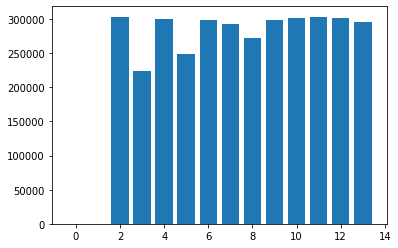

In [127]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
 
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=5)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [128]:
# fit the model
model = LinearRegression()
model.fit(X_train_fs, y_train)

# evaluate the model
yhat = model.predict(X_test_fs)

# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
score=r2_score(y_test,yhat)

print('r2 score is ',score)
print('mean_sqrd_error is =',mean_squared_error(y_test,yhat))
print('root_mean_squared error of is =',np.sqrt(mean_squared_error(y_test,yhat)))
print('MAE: %.3f' % mae)

r2 score is  0.9072077151671256
mean_sqrd_error is = 61304.49464172689
root_mean_squared error of is = 247.5974447398981
MAE: 46.663


In [136]:
predicting_data_pd = predicting_data.toPandas()
x = predicting_data_pd.drop(['merchant_name', 'merchant_abn', 'categories', 'null', 'null', 'future_count'], axis=1)
x.head(5)

,year,month,count,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,Female,Male,Undisclosed
0,2022,2,59,1,14,0,7,4,3,23,7,19,37,3
1,2022,2,311,1,102,3,36,37,15,62,55,133,147,31
2,2022,2,4,0,1,0,0,0,0,2,1,0,4,0
3,2022,2,6,0,1,1,1,0,0,3,0,3,3,0
4,2022,2,106,1,38,4,10,10,7,22,14,44,51,11


In [137]:
print(type(fs.scores_))

<class 'numpy.ndarray'>


In [138]:
y_prediction =  LR.predict(x)
y_prediction

array([ 38.27413155, 252.98144858, -12.49934741, ...,  -5.86619159,
       -12.45876637, -17.4151835 ])

In [141]:
x['prediction'] = y_prediction

In [143]:
x.head(10)

,year,month,count,ACT,NSW,NT,QLD,SA,TAS,VIC,WA,Female,Male,Undisclosed,prediction
0,2022,2,59,1,14,0,7,4,3,23,7,19,37,3,38.274132
1,2022,2,311,1,102,3,36,37,15,62,55,133,147,31,252.981449
2,2022,2,4,0,1,0,0,0,0,2,1,0,4,0,-12.499347
3,2022,2,6,0,1,1,1,0,0,3,0,3,3,0,-8.381468
4,2022,2,106,1,38,4,10,10,7,22,14,44,51,11,74.088811
5,2022,2,1,0,0,0,0,0,0,0,1,1,0,0,-17.415183
6,2022,2,2,0,0,0,0,1,0,1,0,2,0,0,-16.811200
7,2022,2,1,1,0,0,0,0,0,0,0,0,1,0,-13.636192
8,2022,2,111,0,27,1,17,18,4,25,19,48,54,9,93.455273
9,2022,2,582,4,153,9,93,65,23,135,100,285,247,50,527.834626


In [150]:
predictions_df = pd.merge(x, predicting_data_pd, how='left', 
                                          left_on=['year', 'month', 'count', 'ACT', 'NSW', 'NT', 'QLD', 'SA', 
                                                   'TAS', 'VIC', 'WA', 'Female', 'Male', 'Undisclosed'], 
                                          right_on = ['year', 'month', 'count', 'ACT', 'NSW', 'NT', 'QLD', 'SA', 
                                                   'TAS', 'VIC', 'WA', 'Female', 'Male', 'Undisclosed'])

predictions_df.head()


,year,month,count,ACT,NSW,NT,QLD,SA,TAS,VIC,...,Female,Male,Undisclosed,prediction,merchant_name,merchant_abn,categories,null,null,future_count
0,2022,2,59,1,14,0,7,4,3,23,...,19,37,3,38.274132,Scelerisque LLP,58727332026,artist supply And craft shops,0,0,0
1,2022,2,311,1,102,3,36,37,15,62,...,133,147,31,252.981449,Diam Eu Dolor PC,39211701585,shoe shops,0,0,0
2,2022,2,4,0,1,0,0,0,0,2,...,0,4,0,-12.499347,Congue Turpis Limited,66522814831,art dealers and galleries,0,0,0
3,2022,2,6,0,1,1,1,0,0,3,...,3,3,0,-8.381468,Aenean LLP,74084069481,"music shops - musical instruments, pianos, and...",0,0,0
4,2022,2,106,1,38,4,10,10,7,22,...,44,51,11,74.088811,Felis Institute,49167531725,"digital goods: books, movies, music",0,0,0


In [152]:
no_cust_ranking_feature = predictions_df[['merchant_name','merchant_abn','prediction']]
no_cust_ranking_feature.head(5)

,merchant_name,merchant_abn,prediction
0,Scelerisque LLP,58727332026,38.274132
1,Diam Eu Dolor PC,39211701585,252.981449
2,Congue Turpis Limited,66522814831,-12.499347
3,Aenean LLP,74084069481,-8.381468
4,Felis Institute,49167531725,74.088811
